# PROBLEMAS DE LA OPTIMIZACIÓN MEDIA-VARIANZA DE CARTERAS DE ACTIVOS

Aunque las técnicas de optimización de media-varianza son útiles para construir carteras, hay varios problemas al aplicarlas en la práctica que los quants deben tener en cuenta.

Un posible problema inicial de un enfoque de media-varianza está relacionado con el **error de estimación de los parámetros de entrada.**

Para llevar a cabo una optimización de media-varianza, necesitamos introducir rendimientos esperados y una matriz de covarianza.

Tanto los rendimientos esperados como la matriz de covarianza se estiman a partir de datos históricos, pero ésta estimacion tendrá errores

### 1. Errores en la estimación de los retornos esperados

Como se demuestra en [Quantitative Finance with Python Cap: 17.3](https://www.routledge.com/Quantitative-Finance-with-Python-A-Practical-Guide-to-Investment-Management/Kelliher/p/book/9781032014432) el error cometido en la estimación de los rendimientos esperados se puede expresar como:

$$\epsilon_{\mu} = \frac{\sigma}{\sqrt{T}}$$

donde:
-  $\epsilon_{\mu}$ es el error cometido en la estimación de la media

- $\sigma$ es la volatilidad del activo

- $T$ es la longitud del periodo de medida

Esto quiere decir que, por ejemplo, para un activo con una volatilidad del 20%, si contamos con los datos de 20 años, el error cometido en la estimación de la media será del 4.47%.

Veamos el efecto que tiene este error en el cálculo de la frontera eficiente. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as stats
import matplotlib.patches as patches
import plotly.express as px
import riskfolio as rp

from utils import dibuja_covar, dibuja_covar_ax, plot_frontier_modif

plt.style.use('ggplot')


In [79]:
#definimos los tickers de los activos que vamos a usar
assets = ['AAPL', 'APA', 'CMCSA', 'CPB', 'JCI', 'MO', 'MSFT', 'TGT']

# Nos bajamos los precios de cierre ajustados entre dos fechas. Elegimos usar 20 años de datos
start = '2003-01-02'
end = '2022-12-31'

prices = yf.download(assets, start=start, end=end)['Adj Close']
ret = prices.pct_change().dropna()

[*********************100%%**********************]  8 of 8 completed


1- Con los retornos bajados, calculamos y pintamos la frontera eficiente empleando la librería [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/).

In [5]:
# Building the portfolio object
port = rp.Portfolio(returns=ret)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

In [6]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

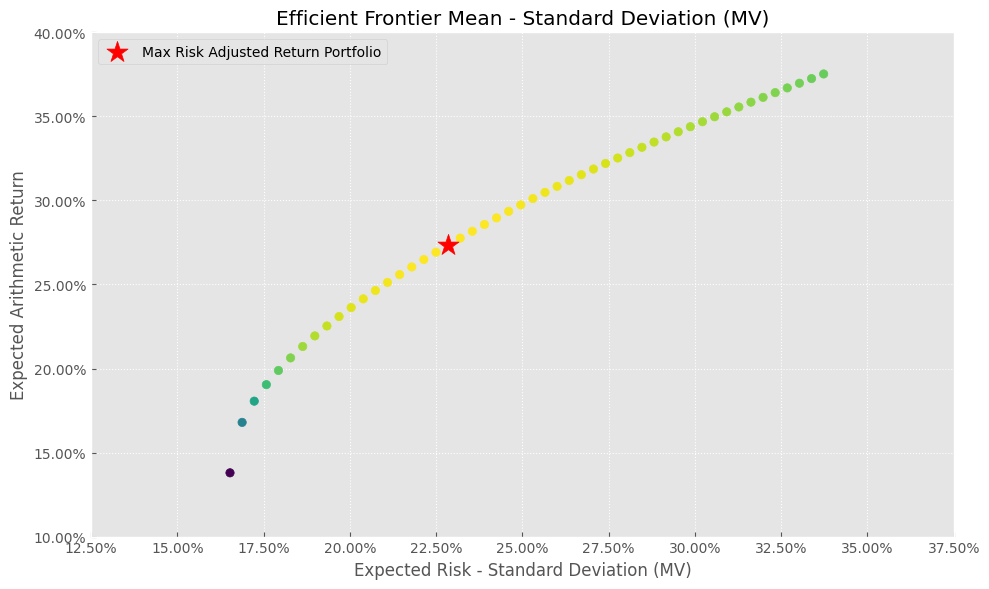

In [7]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = plot_frontier_modif(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

2- Calculamos los errores cometidos en la estimación de los rendimientos esperados para cada activo de nuestro universo de inversión.

Usamos la fórmula: 
$$\epsilon_{\mu} = \frac{\sigma}{\sqrt{T}}$$

In [ ]:
ret_mean_año = ret.mean(axis=0)*252
ret_std_año = ret.std(axis=0)*np.sqrt(252)
ret_cov = ret.cov()
T = 20
errors = ret_std_año/np.sqrt(T)

En una primera aproximación, generamos una matriz de erores de forma que, para cada activo, el error de cada día siga una distribución uniforme entre 
$1-\epsilon_{\mu}$  y  $1+ \epsilon_{\mu}$

Luego multiplicamos los retornos históricos por esa matriz de errores.

In [8]:
mat_error = np.random.uniform(1 - ret_std_año, 1 + ret_std_año, size=(ret.shape[0], ret.shape[1]))

ret_error = ret * mat_error

Calculamos y dibujamos la frontera eficiente con los retornos con errores siguiendo distribución uniforme.

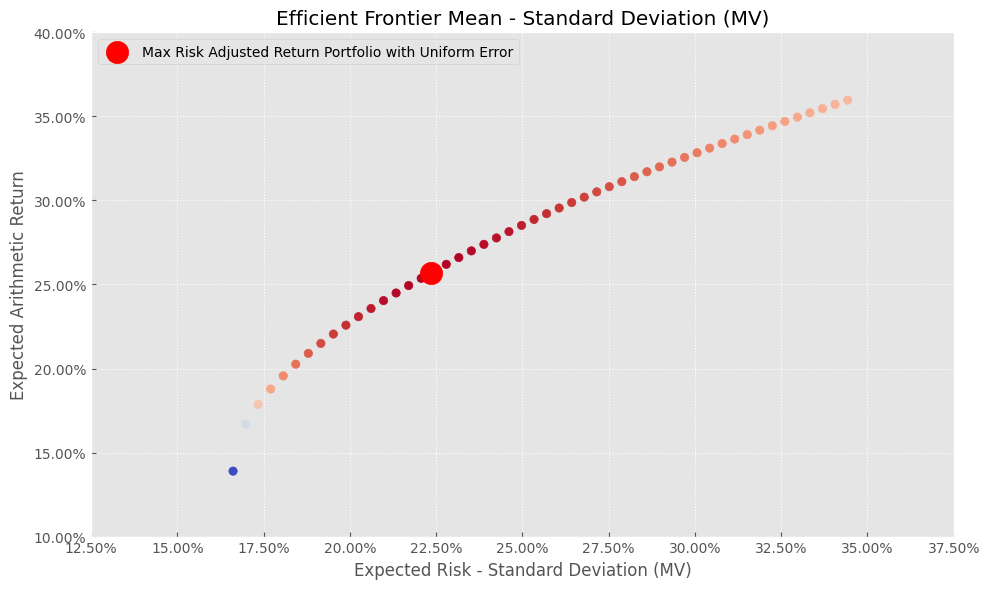

In [49]:
port_error = rp.Portfolio(returns=ret_error)

port_error.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

w_error = port_error.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

frontier_error = port_error.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

w_error = port_error.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)


label_err = 'Max Risk Adjusted Return Portfolio with Uniform Error' # Title of point
mu_error = port_error.mu # Expected returns
cov_error = port_error.cov # Covariance matrix
returns_error = port_error.returns # Returns of the assets

ax = plot_frontier_modif(w_frontier=frontier_error, mu=mu_error, cov=cov_error, returns=ret_error, rm=rm,
                      rf=rf, alpha=0.05, cmap='coolwarm', w=w_error, label=label_err,
                      marker='o', s=16, c='r', height=6, width=10, ax=None)

Ahora graficamos las dos fronteras eficientes para ver el efecto de los errores en los retornos

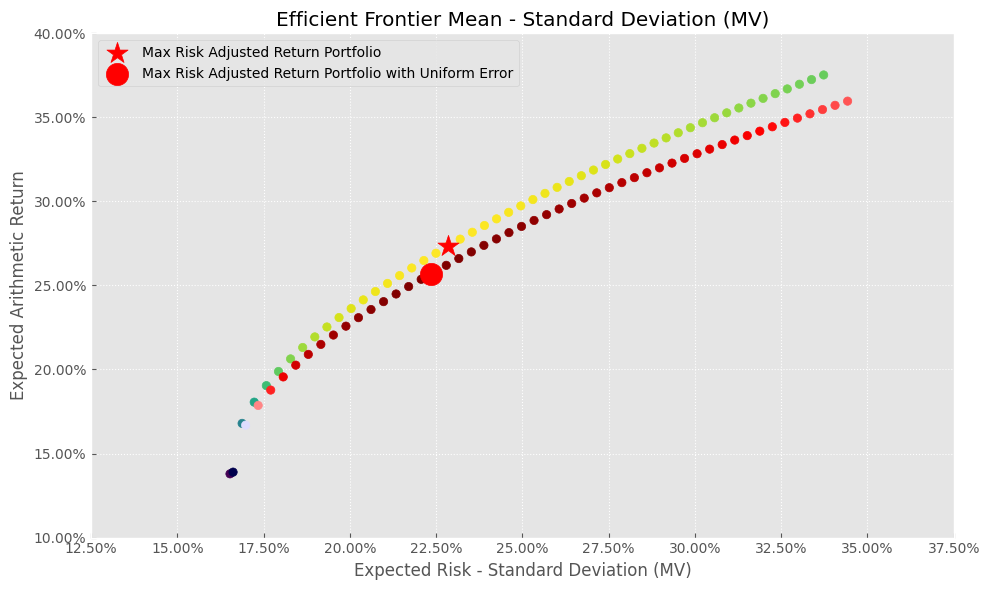

In [50]:
ax = plot_frontier_modif(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

ax = plot_frontier_modif(w_frontier=frontier_error, mu=mu_error, cov=cov_error, returns=ret_error, rm=rm,
                      rf=rf, alpha=0.05, cmap='seismic', w=w_error, label=label_err,
                      marker='o', s=16, c='r', height=6, width=10, ax=None)

Para ver el efecto de errors más grandes, repetimos el proceso de la matriz de los erroes, pero ahora los errores toman valores $1-\epsilon_{\mu}$, $0$  y  $1+ \epsilon_{\mu}$

Para ello generamos un array con los tres posibles valores de error para cada activo y luego generamos una matriz de errores con esos valores.

In [30]:
err_posibles = np.zeros((len(ret_std_año), 3)) #Array con los posibles errores para cada activo

for i in range(len(ret_std_año)):
    err_posibles[i] = np.array([1-ret_std_año[i], 0, 1+ret_std_año[i]])

/tmp/ipykernel_15503/3588314336.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  err_posibles[i] = np.array([1-ret_std_año[i], 0, 1+ret_std_año[i]])


In [51]:
mat_error_max = np.zeros_like(ret) #Array con los errores elegidos para cada activo. Lo inicializamos a cero    

for i in range(len(ret_std_año)):
    mat_error_max[:, i] = np.random.choice(err_posibles[i], size=ret.shape[0])

ret_error_max = ret * mat_error_max #Array con los retornos con los errores elegidos

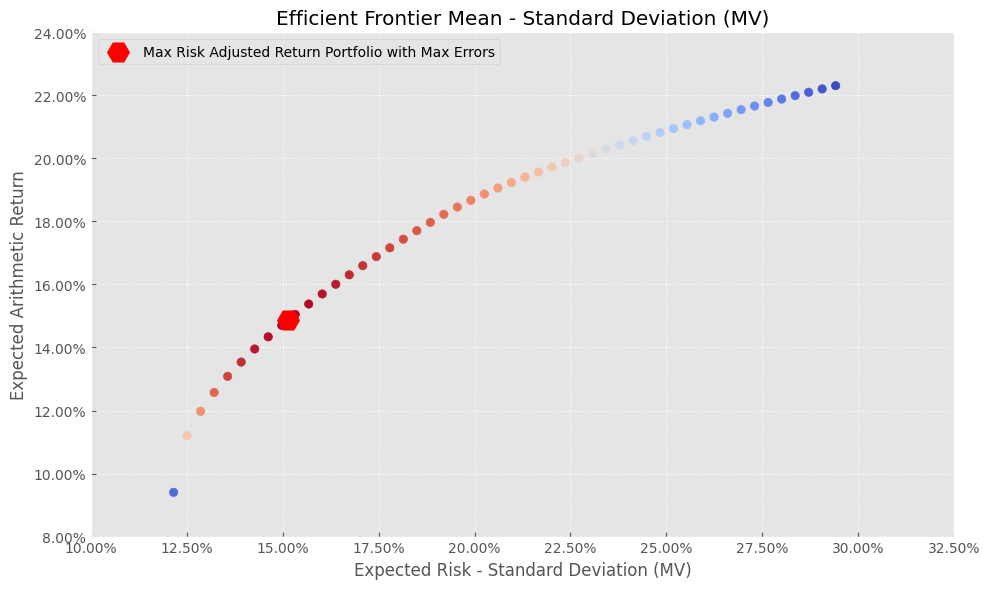

In [52]:
port_error_max = rp.Portfolio(returns=ret_error_max)

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port_error_max.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

w_error_max = port_error_max.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

frontier_error_max = port_error_max.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

#w_error_max = port_error_max.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)


label_err_max = 'Max Risk Adjusted Return Portfolio with Max Errors' # Title of point
mu_error_max = port_error_max.mu # Expected returns
cov_error_max = port_error_max.cov # Covariance matrix
returns_error_max = port_error_max.returns # Returns of the assets

ax = plot_frontier_modif(w_frontier=frontier_error_max, mu=mu_error_max, cov=cov_error_max, returns=ret_error_max, rm=rm,
                      rf=rf, alpha=0.05, cmap='coolwarm', w=w_error_max, label=label_err_max,
                      marker='H', s=16, c='r', height=6, width=10, ax=None)

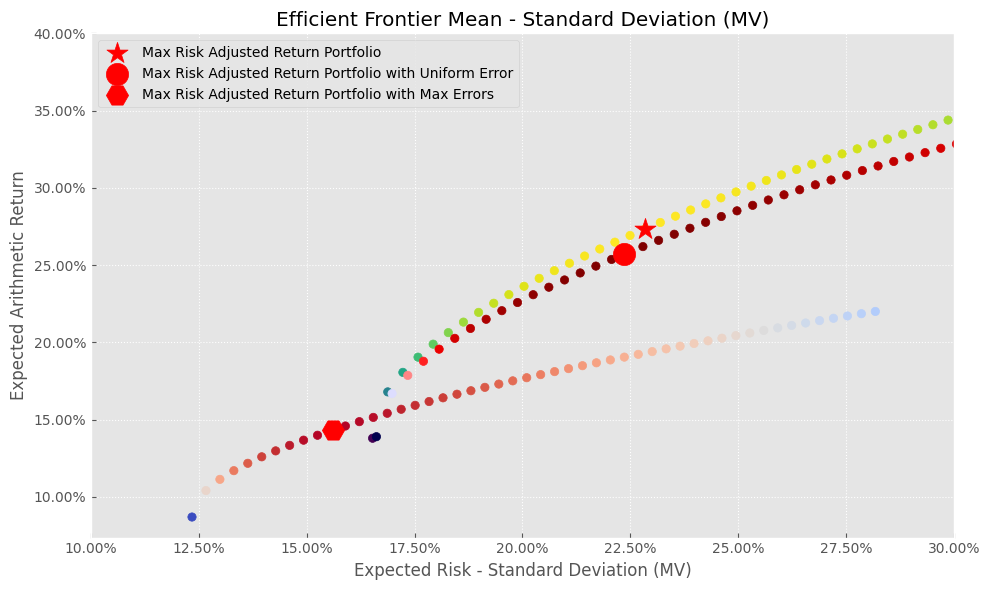

In [48]:
ax = plot_frontier_modif(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

ax = plot_frontier_modif(w_frontier=frontier_error, mu=mu_error, cov=cov_error, returns=ret_error, rm=rm,
                      rf=rf, alpha=0.05, cmap='seismic', w=w_error, label=label_err,
                      marker='o', s=16, c='r', height=6, width=10, ax=None)

ax = plot_frontier_modif(w_frontier=frontier_error_max, mu=mu_error_max, cov=cov_error_max, returns=ret_error_max, rm=rm,
                      rf=rf, alpha=0.05, cmap='coolwarm', w=w_error_max, label=label_err_max,
                      marker='H', s=16, c='r', height=6, width=10, ax=None)



### 2. Errores en la estimación de la matriz de covarianzas


Como se demuestra en [Quantitative Finance with Python Cap: 17.3](https://www.routledge.com/Quantitative-Finance-with-Python-A-Practical-Guide-to-Investment-Management/Kelliher/p/book/9781032014432) el error cometido en la estimación de la matriz de covarianzas se puede expresar como:

$$\epsilon_{var} = 2 * \left (\frac{T}{\Delta_{T}} -1 \right )^{-1} * \sigma^2$$

donde:
-  $\epsilon_{var}$ es el error cometido en la estimación de la varianza

- $\sigma^2$ es la varianza del activo

- $T$ es la longitud del periodo de medida

- $\Delta_{T}$ es el intervalo de tiempo entre dos observaciones consecutivas

La diferencia clave entre el error de estimación en una estimación de varianza y una estimación de rendimiento esperado es la presencia de $\Delta_{T}$ en la ecuación de error de varianza.

Esto significa que para obtener una estimación más precisa de la varianza, podemos simplemente tomar muestras de datos con más frecuencia.



In [ ]:
ret_mean_año = ret.mean(axis=0)*252
ret_var_año = ret.var(axis=0)*252
ret_cov = ret.cov()
T = 20
errors = ret_std_año/np.sqrt(T)

In [100]:
prices_año = prices.resample('BYS').first()
ret_año = prices_año.pct_change().dropna()
ret_año_var = ret_año.var(axis=0)

In [103]:
2 * (20-1)**(-1) * ret_año_var

AAPL     0.039875
APA      0.016099
CMCSA    0.007032
CPB      0.003882
JCI      0.013723
MO       0.004224
MSFT     0.006628
TGT      0.008088
dtype: float64